In [1]:
import argparse  # Commandline input

import matplotlib.pyplot as plt
import numpy as np
from astropy.utils.data import download_file  # or use curl

# To get info about the GW events
from pycbc.catalog import Catalog, Merger

# used for setting priors or initial points of walkers
from pycbc.distributions import JointDistribution, SinAngle, Uniform

# Signal processing and Matched filtering
from pycbc.filter import highpass, matched_filter, resample_to_delta_t, sigma
from pycbc.frame import read_frame  # read the GW data which is in gwf format

# likelihood and stochastic samplers
from pycbc.inference import models, sampler

# BaseModel is inherited and used to make manual models
from pycbc.inference.models.base import BaseModel

# PSD estimation
from pycbc.psd import interpolate, inverse_spectrum_truncation

# td referes to time domain, there is equivalently frequency domain (get_fd_waveform)
from pycbc.waveform import get_td_waveform  # Generate GWaveforms
from scipy.stats import norm
from IPython.display import Image # Generate image of posterior
from IPython.display import HTML # Generate summary of the posterior results

In [2]:
def gw_data(detector, event_name):
    # Download the gravitational wave data for GW170817
    url = "https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/{}-{}1_GWOSC_4KHZ_R1-1126257415-4096.gwf"
    # Downloading "H-H1_LOSC_4_V2-1128678884-32.gwf" file or  use curl method to download
    fname = download_file(url.format(detector[0], detector[0]), cache=True)
    

    m = c["GW150914-v3"]
    # read_frame(file_name, channel_name, start, end); channels names is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1
    data = read_frame(fname, f"{detector}:GWOSC-4KHZ_R1_STRAIN", start_time=int(m.time - 260), end_time=int(m.time + 40))
    # Read the data directly from the Gravitational-Wave Frame (GWF) file. or
    # this data can be obtained by m = Merger("GW170817"); data = m.strain("H1")
    # This method by default gets the smallest version of the dataset. If additional data or specific versions are required,
    # use the method which is used in this.py file

 
    # Convert to a frequency series by taking the data's FFT
    data_freq = data.to_frequencyseries()

    return data, data_freq, fname

c = Catalog("gwtc-1")
event_name = "GW150914-v3"
ifos = ["H1", "L1"]  # List of observatories we'll analyze
# Storing GW data (timeseries) of all detectors in dictionary format
data = {}
# Storing GW data (frequency domain)  of all detectors in dictionary format
data_freq = {}
fname = {}
for i in ifos:
    print("Reading GW timeseries and freq domain data for detector ", i)
    data[i], data_freq[i], fname[i] = gw_data(detector=i, event_name=event_name)


Reading GW timeseries and freq domain data for detector  H1
Reading GW timeseries and freq domain data for detector  L1


In [3]:
print("Mass 1 in source frame", c["GW150914-v3"].median1d("mass1"))
print("Mass 2 in source frame", c["GW150914-v3"].median1d("mass2"))

Mass 1 in source frame 35.6
Mass 2 in source frame 30.6


In [4]:
mass1 = c["GW150914-v3"].median1d("mass1")*(1+c["GW150914-v3"].median1d("redshift"))
mass2 = c["GW150914-v3"].median1d("mass2")*(1+c["GW150914-v3"].median1d("redshift"))
print(f"Mass 1 in detector frame {mass1}")
print(f"Mass 2 in detector frame {mass2}")

Mass 1 in detector frame 38.804
Mass 2 in detector frame 33.354000000000006


In [5]:
prior_config = """
[variable_params]
distance =
inclination =
delta_tc =
ra = 
dec =

[static_params]
mass1 = 38.804
mass2 = 33.354
f_lower = 20.0
approximant = TaylorF2
polarization = 0


[prior-distance]
name = uniform
min-distance = 10
max-distance = 1000

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[prior-ra+dec]
; sky position prior
name = uniform_sky

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [6]:
!echo '{prior_config}' > prior_gw150914.ini
!cat prior_gw150914.ini



[variable_params]
distance =
inclination =
delta_tc =
ra = 
dec =

[static_params]
mass1 = 38.804
mass2 = 33.354
f_lower = 20.0
approximant = TaylorF2
polarization = 0


[prior-distance]
name = uniform
min-distance = 10
max-distance = 1000

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[prior-ra+dec]
; sky position prior
name = uniform_sky

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [7]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""

In [8]:
!echo '{sampler_config}' > sampler_gw150914.ini
!cat sampler_gw150914.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



In [9]:
data_config_gw150914 = """
[data]
instruments = H1 L1
trigger-time = {event_tc}
analysis-start-time = -6
analysis-end-time = 2
; Is this the inspiral end time?
strain-high-pass = 20
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file}
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN
""".format(event_tc=c["GW150914-v3"].time,
           h1file=fname['H1'],
           l1file=fname['L1'])

In [10]:
!echo '{data_config_gw150914}' > data_gw150914.ini
!cat data_gw150914.ini


[data]
instruments = H1 L1
trigger-time = 1126259462.4
analysis-start-time = -6
analysis-end-time = 2
; Is this the inspiral end time?
strain-high-pass = 20
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
pad-data = 8
sample-rate = 2048
frame-files = H1:/home/ash/.astropy/cache/download/url/4f55654a7290cf4206f47be3a1350a5d/contents L1:/home/ash/.astropy/cache/download/url/7546dc58214eb73e476b94c0ac216191/contents
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN



In [11]:
model_config = """
[model]
name = single_template
low-frequency-cutoff = 20.
ignore-failed-waveforms =
"""

In [12]:
!echo '{model_config}' > model_gw150914.ini # Why model_config in such a way???
!cat model_gw150914.ini


[model]
name = single_template
low-frequency-cutoff = 20.
ignore-failed-waveforms =



In [13]:
!pycbc_inference --verbose \
    --seed 1998 \
    --config-files data_gw150914.ini sampler_gw150914.ini prior_gw150914.ini model_gw150914.ini\
    --output-file inference_gw150914.hdf \
    --nprocesses 4 \
    --force    

2022-09-02 16:08:14,816 Using seed 1998
2022-09-02 16:08:14,817 Running with CPU support: 1 threads
2022-09-02 16:08:14,866 Reading configuration file
2022-09-02 16:08:14,874 Setting up model
2022-09-02 16:08:14,878 Setting up priors for each parameter
2022-09-02 16:08:14,880 No sampling_params section read from config file
2022-09-02 16:08:14,880 Loading waveform transforms
2022-09-02 16:08:14,887 Determining analysis times to use
2022-09-02 16:08:14,888 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 16:08:14,888 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 16:08:14,890 Reading Frames
2022-09-02 16:08:42,062 Highpass Filtering
2022-09-02 16:08:42,083 Resampling data
2022-09-02 16:08:42,193 Converting to float64
2022-09-02 16:08:42,200 Highpass Filtering
2022-09-02 16:08:42,206 Remove Padding
2022-09-02 16:08:42,207 Readin

In [14]:
!pycbc_inference_plot_posterior --verbose --input-file inference_gw150914.hdf \
        --output-file posterior_gw150914.png \
        --plot-scatter --plot-marginal --z-arg snr

2022-09-02 16:12:23,982 Reading input file inference_gw150914.hdf
2022-09-02 16:12:23,984 Loading samples
2022-09-02 16:12:24,001 Loaded 1400 samples
2022-09-02 16:12:24,002 Getting samples for colorbar
2022-09-02 16:12:24,011 Plotting
2022-09-02 16:12:28,155 Done


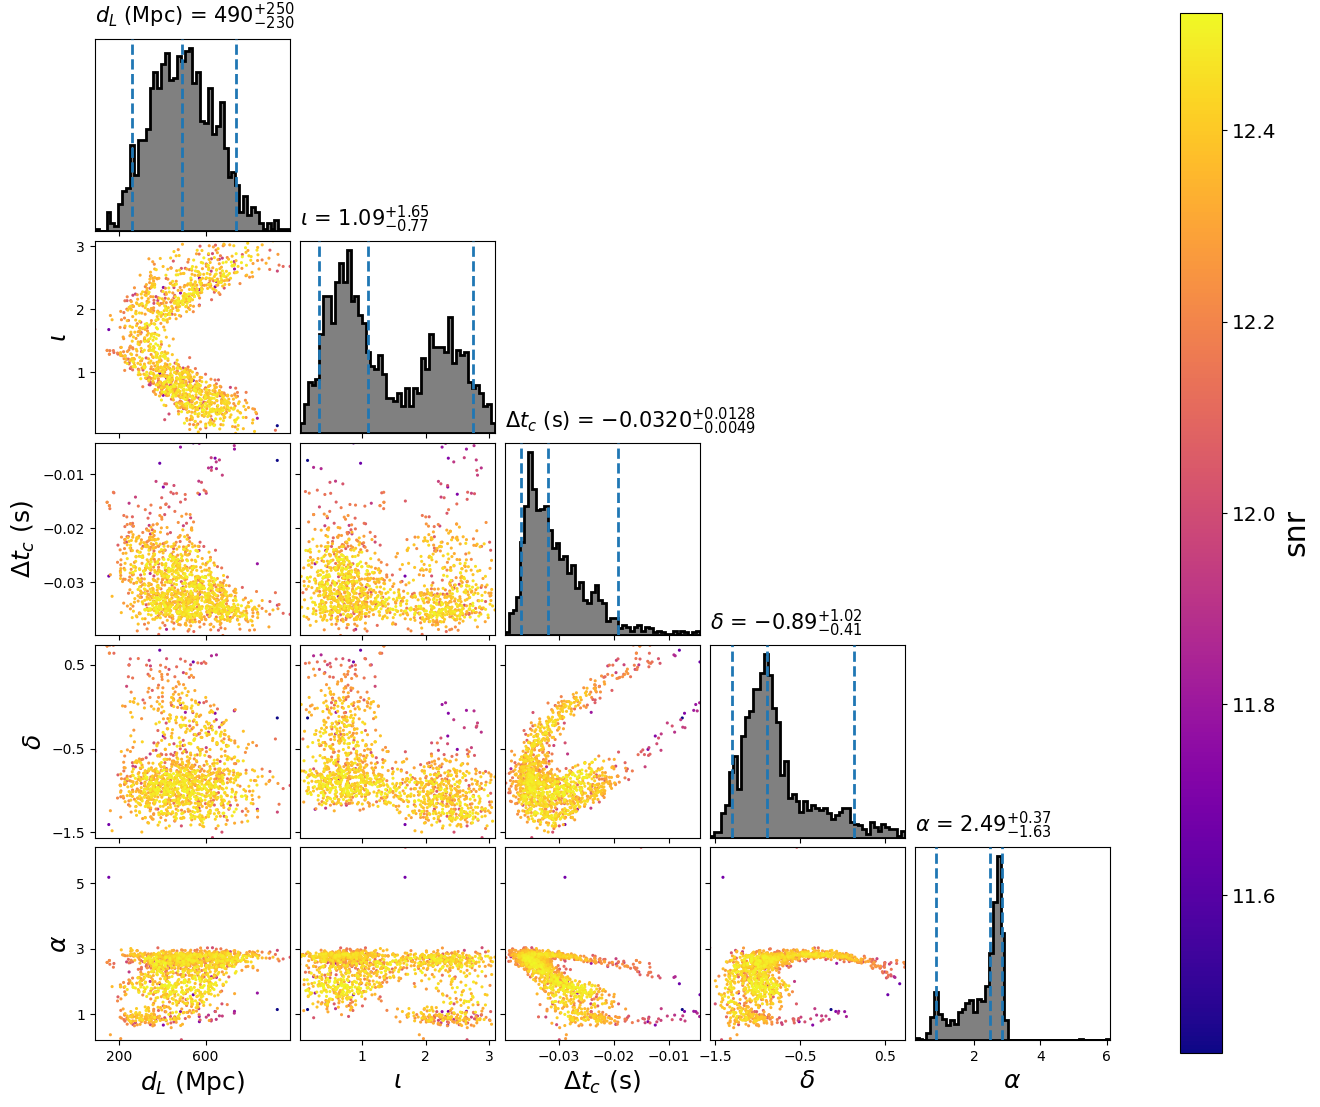

In [15]:
Image('posterior_gw150914.png', height=480)

In [16]:
c["GW150914-v3"].median1d("distance")* (1 + c["GW150914-v3"].median1d("redshift"))

479.6

In [17]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference_gw150914.hdf \
    --output-file posterior-dist_inc_gw150914.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters inclination distance --expected-parameters 'distance:479.6'

2022-09-02 16:12:36,860 Reading input file inference_gw150914.hdf
2022-09-02 16:12:36,863 Loading samples
2022-09-02 16:12:36,876 Loaded 1400 samples
2022-09-02 16:12:36,877 Plotting
2022-09-02 16:12:39,260 Done


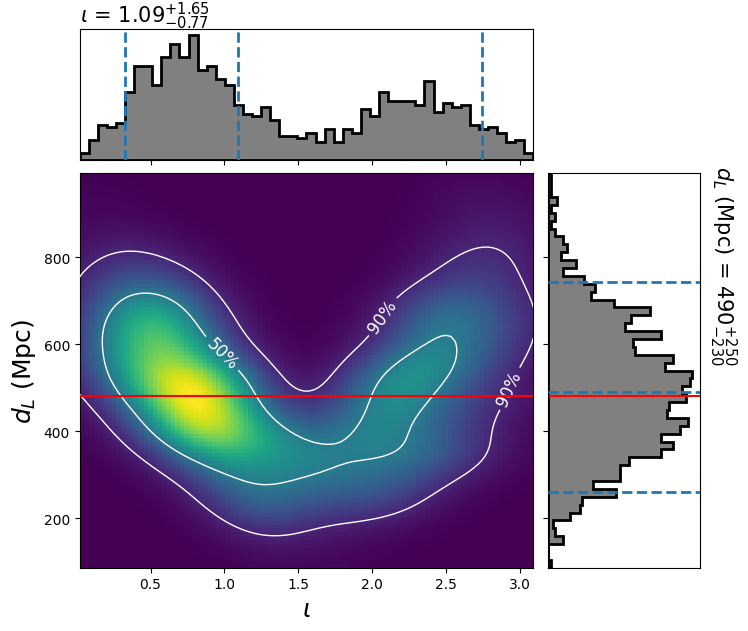

In [18]:
Image('posterior-dist_inc_gw150914.png', height=480)

In [19]:
!pycbc_inference_table_summary \
    --input-file inference_gw150914.hdf \
    --output-file posterior_summary.html \
    --verbose

2022-09-02 16:12:48,257 Reading input file inference_gw150914.hdf
2022-09-02 16:12:48,259 Loading samples
2022-09-02 16:12:48,275 Loaded 1400 samples


In [20]:
HTML('posterior_summary.html')

Parameter,90% Credible Interval,Maximum Posterior,Maximum Likelihood
$\iota$,$1.09^{+1.65}_{-0.77}$,$0.95$,$0.40$
$\delta$,$-0.89^{+1.02}_{-0.41}$,$-0.84$,$-1.05$
$d_L$ (Mpc),$490^{+250}_{-230}$,$330$,$590$
$\alpha$,$2.49^{+0.37}_{-1.63}$,$1.82$,$1.81$
$\Delta t_c~(\rm{s})$,$-0.0320^{+0.0128}_{-0.0049}$,$-0.0266$,$-0.0291$


In [21]:
model_config_mass_GW150914 = """
[model]
name = relative
low-frequency-cutoff = 20.0
epsilon = 0.03
mass1_ref = 38.804
mass2_ref = 33.354
tc_ref = ${data|trigger-time}
ignore-failed-waveforms =
"""

In [22]:
!echo '{model_config_mass_GW150914}' > model_config_mass_GW150914.ini
!cat model_config_mass_GW150914.ini


[model]
name = relative
low-frequency-cutoff = 20.0
epsilon = 0.03
mass1_ref = 38.804
mass2_ref = 33.354
tc_ref = ${data|trigger-time}
ignore-failed-waveforms =



In [23]:
prior_config_mass_GW150914 = """
[variable_params]
spin1z = 
spin2z =

[static_params]
f_lower = 20.0
approximant = IMRPhenomPv2
polarization = 0
ra = 2.52
dec = -0.91
distance = 500
inclination = 1.09
delta_tc = -0.03
mass1 = 38.804
mass2 = 33.354

[prior-spin1z]
name = uniform
min-spin1z = 0
max-spin1z = 1

[prior-spin2z]
name = uniform
min-spin2z = 0
max-spin2z = 1



[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""
# [prior-mchirp]
# ; chirp mass prior
# name = uniform
# min-mchirp = 1.1
# max-mchirp = 1.35

# [prior-eta]
# ; symmetric mass ratio prior
# name = uniform
# min-eta = 0.15
# max-eta = 0.30



# [waveform_transforms-mass1+mass2]
# ; transform from mchirp, eta to mass1, mass2 for waveform generation
# name = mchirp_eta_to_mass1_mass2

In [24]:
!echo '{prior_config_mass_GW150914}' > prior_config_mass_GW150914.ini
!cat prior_config_mass_GW150914.ini


[variable_params]
spin1z = 
spin2z =

[static_params]
f_lower = 20.0
approximant = IMRPhenomPv2
polarization = 0
ra = 2.52
dec = -0.91
distance = 500
inclination = 1.09
delta_tc = -0.03
mass1 = 38.804
mass2 = 33.354

[prior-spin1z]
name = uniform
min-spin1z = 0
max-spin1z = 1

[prior-spin2z]
name = uniform
min-spin2z = 0
max-spin2z = 1



[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [25]:
!pycbc_inference --verbose \
    --seed 1998 \
    --config-files data_gw150914.ini sampler_gw150914.ini prior_config_mass_GW150914.ini model_config_mass_GW150914.ini\
    --output-file inference_gw150914.hdf \
    --nprocesses 4 \
    --force    

2022-09-02 16:12:56,952 Using seed 1998
2022-09-02 16:12:56,952 Running with CPU support: 1 threads
2022-09-02 16:12:56,989 Reading configuration file
2022-09-02 16:12:56,993 Setting up model
2022-09-02 16:12:56,995 Setting up priors for each parameter
2022-09-02 16:12:56,996 No sampling_params section read from config file
2022-09-02 16:12:56,996 Loading waveform transforms
2022-09-02 16:12:57,001 Determining analysis times to use
2022-09-02 16:12:57,001 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 16:12:57,001 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 16:12:57,002 Reading Frames
2022-09-02 16:13:22,755 Highpass Filtering
2022-09-02 16:13:22,772 Resampling data
2022-09-02 16:13:22,849 Converting to float64
2022-09-02 16:13:22,849 Highpass Filtering
2022-09-02 16:13:22,859 Remove Padding
2022-09-02 16:13:22,861 Readin

In [26]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference_gw150914.hdf \
    --output-file posterior-dist_inc_gw150914.png \
    --plot-density --plot-contours --plot-marginal 

2022-09-02 16:18:59,829 Reading input file inference_gw150914.hdf
2022-09-02 16:18:59,832 Loading samples
2022-09-02 16:18:59,847 Loaded 3000 samples
2022-09-02 16:18:59,847 Plotting
2022-09-02 16:19:03,455 Done


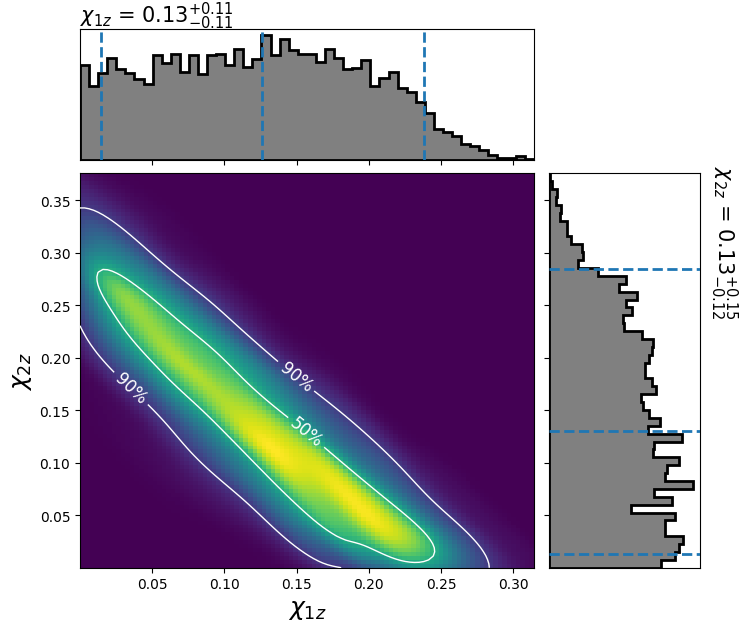

In [27]:
Image('posterior-dist_inc_gw150914.png', height=480)

In [28]:
!pycbc_inference_table_summary \
    --input-file inference_gw150914.hdf \
    --output-file posterior_summary.html \
    --verbose

2022-09-02 16:19:11,244 Reading input file inference_gw150914.hdf
2022-09-02 16:19:11,246 Loading samples
2022-09-02 16:19:11,268 Loaded 3000 samples


In [29]:
HTML('posterior_summary.html')

Parameter,90% Credible Interval,Maximum Posterior,Maximum Likelihood
$\chi_{2z}$,$0.13^{+0.15}_{-0.12}$,$0.00$,$0.00$
$\chi_{1z}$,$0.13^{+0.11}_{-0.11}$,$0.23$,$0.23$


In [30]:
prior_config_mass_GW150914 = """
[variable_params]
mass1 =
mass2 = 

[static_params]
f_lower = 20.0
approximant = IMRPhenomPv2
polarization = 0
ra = 2.52
dec = -0.91
distance = 500
inclination = 1.09
delta_tc = -0.03
spin1z = 0.13
spin2z = 0.13

[prior-mass1]
name = uniform
min-mass1 = 20
max-mass1 = 50

[prior-mass2]
name = uniform
min-mass2 = 15
max-mass2 = 40

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""
# [prior-eta]
# ; symmetric mass ratio prior
# name = uniform
# min-eta = 0.15
# max-eta = 0.30

# [prior-spin1z]
# name = uniform
# min-spin1z = -0.4
# max-spin1z = 0.4

# [prior-spin2z]
# name = uniform
# min-spin2z = -0.4
# max-spin2z = 0.4

# [waveform_transforms-mass1+mass2]
# ; transform from mchirp, eta to mass1, mass2 for waveform generation
# name = mchirp_eta_to_mass1_mass2

In [31]:
!echo '{prior_config_mass_GW150914}' > prior_config_mass_GW150914.ini
!cat prior_config_mass_GW150914.ini


[variable_params]
mass1 =
mass2 = 

[static_params]
f_lower = 20.0
approximant = IMRPhenomPv2
polarization = 0
ra = 2.52
dec = -0.91
distance = 500
inclination = 1.09
delta_tc = -0.03
spin1z = 0.13
spin2z = 0.13

[prior-mass1]
name = uniform
min-mass1 = 20
max-mass1 = 50

[prior-mass2]
name = uniform
min-mass2 = 15
max-mass2 = 40

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [32]:
sampler_config_adv = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain

;   Sampling transforms

[sampling_params]
mass1, mass2  : mchirp, q


[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q
"""


In [33]:
!echo '{sampler_config_adv}' > sampler_gw150914_adv.ini
!cat sampler_gw150914_adv.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain

;   Sampling transforms

[sampling_params]
mass1, mass2  : mchirp, q


[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q



In [34]:
!pycbc_inference --verbose \
    --seed 1998 \
    --config-files data_gw150914.ini sampler_gw150914_adv.ini prior_config_mass_GW150914.ini model_config_mass_GW150914.ini\
    --output-file inference_gw150914.hdf \
    --nprocesses 4 \
    --force    

2022-09-02 16:19:20,267 Using seed 1998
2022-09-02 16:19:20,267 Running with CPU support: 1 threads
2022-09-02 16:19:20,306 Reading configuration file
2022-09-02 16:19:20,311 Setting up model
2022-09-02 16:19:20,315 Setting up priors for each parameter
2022-09-02 16:19:20,317 Sampling in mchirp, q in place of mass1, mass2
2022-09-02 16:19:20,317 Loading waveform transforms
2022-09-02 16:19:20,325 Determining analysis times to use
2022-09-02 16:19:20,325 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 16:19:20,325 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 16:19:20,327 Reading Frames
2022-09-02 16:19:48,864 Highpass Filtering
2022-09-02 16:19:48,884 Resampling data
2022-09-02 16:19:48,933 Converting to float64
2022-09-02 16:19:48,934 Highpass Filtering
2022-09-02 16:19:48,943 Remove Padding
2022-09-02 16:19:48,944 Reading 

In [35]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference_gw150914.hdf \
    --output-file posterior-dist_inc_gw150914.png \
    --plot-density --plot-contours --plot-marginal 

2022-09-02 16:25:51,607 Reading input file inference_gw150914.hdf
2022-09-02 16:25:51,610 Loading samples
2022-09-02 16:25:51,625 Loaded 1600 samples
2022-09-02 16:25:51,625 Plotting
2022-09-02 16:25:53,887 Done


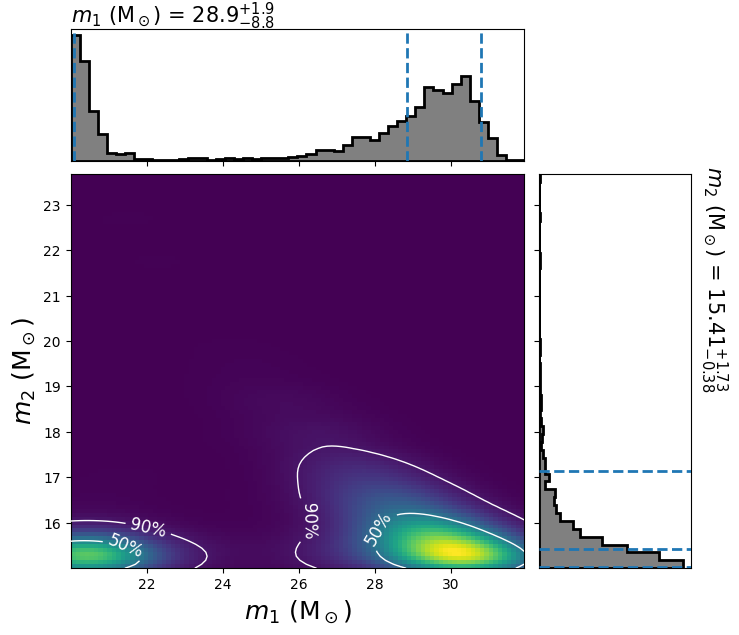

In [36]:

Image('posterior-dist_inc_gw150914.png', height=480)


In [37]:

sampler_config_adv = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain

;   Sampling transforms

[sampling_params]
mass1, mass2  : mchirp, q

[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q
"""

In [38]:
!echo '{sampler_config_adv}' > sampler_gw150914_adv.ini
!cat sampler_gw150914_adv.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain

;   Sampling transforms

[sampling_params]
mass1, mass2  : mchirp, q

[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q



In [39]:
prior_config_mass_GW150914 = """
[variable_params]
q = 
mass1 = 
chi_eff = 
spin1z =

[static_params]
f_lower = 20.0
approximant = IMRPhenomPv2
polarization = 0
ra = 2.52
dec = -0.91
distance = 500
inclination = 1.09
delta_tc = -0.03

[prior-chi_eff]
name = uniform
min-chi_eff = -0.2
max-chi_eff = 0.4

[prior-spin1z]
name = uniform
min-spin1z = 0
max-spin1z = 0.4

[prior-mass1]
name = uniform
min-mass1 = 20
max-mass1 = 50

[prior-q]
name = uniform
min-q = 1
max-q = 1.5

[waveform_transforms-mass2]
name = custom
inputs = mass1, q
mass2 = q*mass1

[waveform_transforms-spin2z]
name = custom
inputs = q, chi_eff, spin1z
spin2z = (chi_eff*(1+q) - spin1z)/q

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""
# [prior-eta]
# ; symmetric mass ratio prior
# name = uniform
# min-eta = 0.15
# max-eta = 0.30


# [waveform_transforms-mass1+mass2]
# ; transform from mchirp, eta to mass1, mass2 for waveform generation
# name = mchirp_eta_to_mass1_mass2

In [40]:
!echo '{prior_config_mass_GW150914}' > prior_config_mass_GW150914.ini
!cat prior_config_mass_GW150914.ini


[variable_params]
q = 
mass1 = 
chi_eff = 
spin1z =

[static_params]
f_lower = 20.0
approximant = IMRPhenomPv2
polarization = 0
ra = 2.52
dec = -0.91
distance = 500
inclination = 1.09
delta_tc = -0.03

[prior-chi_eff]
name = uniform
min-chi_eff = -0.2
max-chi_eff = 0.4

[prior-spin1z]
name = uniform
min-spin1z = 0
max-spin1z = 0.4

[prior-mass1]
name = uniform
min-mass1 = 20
max-mass1 = 50

[prior-q]
name = uniform
min-q = 1
max-q = 1.5

[waveform_transforms-mass2]
name = custom
inputs = mass1, q
mass2 = q*mass1

[waveform_transforms-spin2z]
name = custom
inputs = q, chi_eff, spin1z
spin2z = (chi_eff*(1+q) - spin1z)/q

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [41]:
!pycbc_inference --verbose \
    --seed 1998 \
    --config-files data_gw150914.ini sampler_gw150914.ini prior_config_mass_GW150914.ini model_config_mass_GW150914.ini\
    --output-file inference_gw150914.hdf \
    --nprocesses 4 \
    --force    

2022-09-02 16:26:01,829 Using seed 1998
2022-09-02 16:26:01,830 Running with CPU support: 1 threads
2022-09-02 16:26:01,871 Reading configuration file
2022-09-02 16:26:01,884 Setting up model
2022-09-02 16:26:01,887 Setting up priors for each parameter
2022-09-02 16:26:01,889 No sampling_params section read from config file
2022-09-02 16:26:01,889 Loading waveform transforms
2022-09-02 16:26:01,896 Determining analysis times to use
2022-09-02 16:26:01,896 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 16:26:01,897 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 16:26:01,898 Reading Frames
2022-09-02 16:26:22,822 Highpass Filtering
2022-09-02 16:26:22,841 Resampling data
2022-09-02 16:26:22,914 Converting to float64
2022-09-02 16:26:22,914 Highpass Filtering
2022-09-02 16:26:22,920 Remove Padding
2022-09-02 16:26:22,921 Readin

In [75]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference_gw150914.hdf \
    --output-file posterior-dist_inc_gw150914.png \
    --plot-density --plot-contours --plot-marginal \
    --z-arg snr \
    --parameters q chi_eff 

2022-09-02 16:55:04,828 Reading input file inference_gw150914.hdf
2022-09-02 16:55:04,829 Loading samples
2022-09-02 16:55:04,839 Loaded 1400 samples
2022-09-02 16:55:04,840 Getting samples for colorbar
2022-09-02 16:55:04,847 Plotting
2022-09-02 16:55:07,369 Done


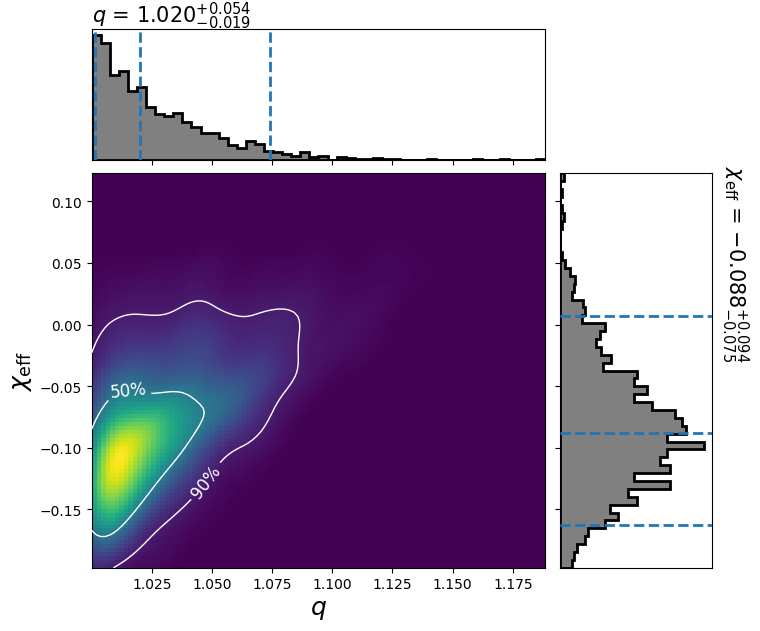

In [76]:
Image('posterior-dist_inc_gw150914.png', height=480)

In [44]:
from pycbc import inference
fp = inference.io.loadfile("inference_gw150914.hdf", "r")

list(fp.keys())

['config_file', 'data', 'sampler_info', 'samples']

In [45]:
list(fp.attrs.items())


[('H1_analysis_segment', array([1.12625945e+09, 1.12625947e+09])),
 ('H1_likelihood_low_freq', 20.0),
 ('H1_psd_segment', array([1.12625921e+09, 1.12625972e+09])),
 ('L1_analysis_segment', array([1.12625945e+09, 1.12625947e+09])),
 ('L1_likelihood_low_freq', 20.0),
 ('L1_psd_segment', array([1.12625921e+09, 1.12625972e+09])),
 ('analyzed_detectors', array(['H1', 'L1'], dtype=object)),
 ('approximant', 'IMRPhenomPv2'),
 ('approximant_ref', 'IMRPhenomPv2'),
 ('cmd',
  array(['/home/ash/.local/bin/pycbc_inference --verbose --seed 1998 --config-files data_gw150914.ini sampler_gw150914.ini prior_config_mass_GW150914.ini model_config_mass_GW150914.ini --output-file inference_gw150914.hdf --nprocesses 4 --force'],
        dtype=object)),
 ('dec', -0.91),
 ('dec_ref', 0.0),
 ('delta_tc', -0.03),
 ('delta_tc_ref', -0.03),
 ('distance', 500.0),
 ('distance_ref', 500.0),
 ('dlog_evidence', 1.5790947177447379),
 ('effective_nsamples', 1400),
 ('f_lower', 20.0),
 ('f_lower_ref', 20.0),
 ('filetype'

In [46]:
list(fp['samples'].keys())

['chi_eff', 'logjacobian', 'loglikelihood', 'logprior', 'mass1', 'q', 'spin1z']

In [47]:
list(fp['samples'].attrs.items())

[('H1_lognl', -31252.52035545496),
 ('L1_lognl', -270598.8969993154),
 ('lognl', -301851.41735477035)]

[(-0.08706826, 0.28578861, 1.00832991, -301893.25225128, 20.35589834)
 (-0.07479997, 0.12521446, 1.01886056, -301893.67768057, 20.25219942)
 (-0.04808025, 0.17320469, 1.07141515, -301894.13847636, 20.03757151) ...
 (-0.136042  , 0.23012264, 1.18319393, -301919.98785731, 23.08612777)
 (-0.17648499, 0.26993898, 1.31886501, -301922.24667396, 25.88677767)
 (-0.18994096, 0.00438737, 1.19786834, -301910.05128154, 22.02354165)]
Length  4200


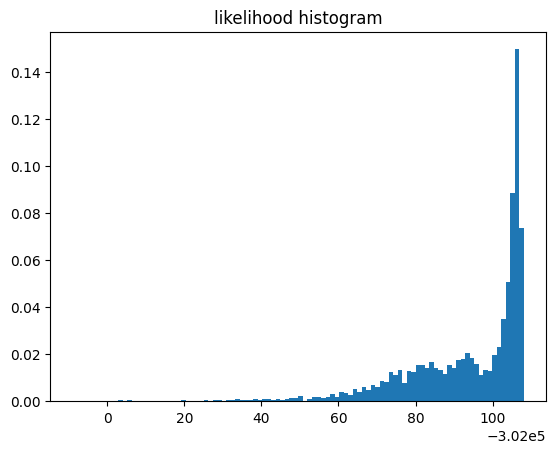

Samples of 90% credible region  [(-0.08706826, 0.28578861, 1.00832991, -301893.25225128, 20.35589834)
 (-0.07479997, 0.12521446, 1.01886056, -301893.67768057, 20.25219942)
 (-0.04808025, 0.17320469, 1.07141515, -301894.13847636, 20.03757151) ...
 ( 0.00661533, 0.35767174, 1.42308867, -301926.34531645, 22.84762513)
 (-0.18817914, 0.02568706, 1.19308157, -301908.96787073, 21.9917583 )
 ( 0.16950077, 0.00218066, 1.27486203, -301913.84653288, 20.56460611)]
Length after removing  3780


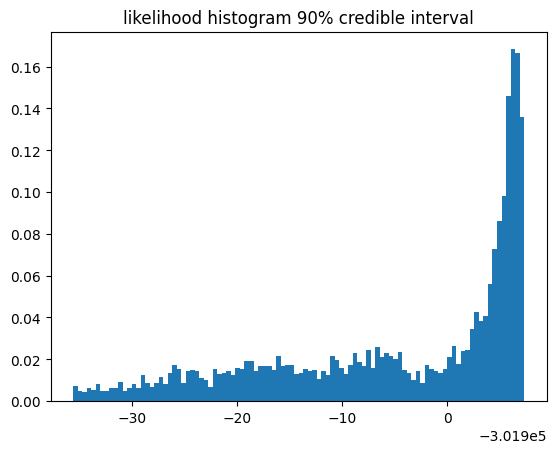

In [98]:
samples = fp.read_samples(['mass1', 'spin1z','q', 'chi_eff', 'loglikelihood'])
print(samples)

loglikelihood = samples['loglikelihood']
q = samples['q']
chi_eff = samples['chi_eff']
mass1 = samples['mass1']
spin1z = samples['spin1z']

print("Length ", len(loglikelihood))

binsize=100
n,bins,patches=plt.hist(loglikelihood,bins=binsize,density=True) 
plt.title("likelihood histogram")
plt.show()

lower = np.percentile(loglikelihood, 50 - 90/2) 
upper = np.percentile(loglikelihood, 50 + 90/2) 
loglikelihood  = loglikelihood[np.intersect1d(np.where(loglikelihood<upper), np.where(loglikelihood>lower))]
q = q[np.intersect1d(np.where(loglikelihood<upper), np.where(loglikelihood>lower))]
chi_eff = chi_eff[np.intersect1d(np.where(loglikelihood<upper), np.where(loglikelihood>lower))]
mass1 = mass1[np.intersect1d(np.where(loglikelihood<upper), np.where(loglikelihood>lower))]
spin1z = spin1z[np.intersect1d(np.where(loglikelihood<upper), np.where(loglikelihood>lower))]

samples = samples[np.intersect1d(np.where(loglikelihood<upper), np.where(loglikelihood>lower))]
print("Samples of 90% credible region ", samples)
print("Length after removing ", len(loglikelihood))

n,bins,patches=plt.hist(loglikelihood,bins=binsize,density=True) 
plt.title("likelihood histogram 90% credible interval")
plt.show()

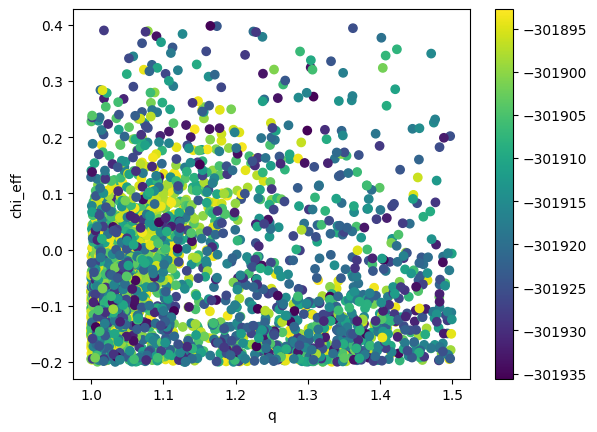

In [99]:
plt.figure()
plt.scatter(q, chi_eff, c=loglikelihood)
plt.xlabel("q")
plt.ylabel("chi_eff")
plt.colorbar()
plt.show()

In [101]:
E1 = (mass1**2) * (1 + np.sqrt(1 - np.abs(spin1z)**2)) # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
mass2 = q*mass1
spin2z = (chi_eff*(1+q) - spin1z)/q
E2 = (mass2**2) * (1 + np.sqrt(1 - np.abs(spin2z)**2)) # Initial Entropy of BH2 

# Ringdown

In [103]:
model_config_ringdown = """
[model]
name = gated_gaussian_margpol
low-frequency-cutoff = 20
"""

In [104]:
!echo '{model_config_ringdown}' > model_GW150914_ringdown.ini
!cat model_GW150914_ringdown.ini


[model]
name = gated_gaussian_margpol
low-frequency-cutoff = 20



In [107]:
data_config_gw150914 = """
[data]
instruments = H1 L1
trigger-time = {event_tc}
analysis-start-time = -6
analysis-end-time = 2
; Is this the inspiral end time?
strain-high-pass = 20
data-conditioning-low-freq = H1:0 L1:0 
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file}
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN
""".format(event_tc=c["GW150914-v3"].time,
           h1file=fname['H1'],
           l1file=fname['L1'])

In [109]:
!echo '{data_config_gw150914}' > data_GW150914_ringdown.ini
!cat data_GW150914_ringdown.ini


[data]
instruments = H1 L1
trigger-time = 1126259462.4
analysis-start-time = -6
analysis-end-time = 2
; Is this the inspiral end time?
strain-high-pass = 20
data-conditioning-low-freq = H1:0 L1:0 
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
pad-data = 8
sample-rate = 2048
frame-files = H1:/home/ash/.astropy/cache/download/url/4f55654a7290cf4206f47be3a1350a5d/contents L1:/home/ash/.astropy/cache/download/url/7546dc58214eb73e476b94c0ac216191/contents
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN



In [115]:
prior_config_mass_GW150914 = """
[variable_params]
; ref_amp (str, optional) - Which mode to use as the reference for computing amplitudes
final_mass = 
final_spin = 
logamp220 = 
; if ref_amp = 'amp220', lmns = ['221', '331'], and no distance is provided, then amp220 = 1e-22, amp330 = 0.1 would result in the 220 mode
;  having a strain amplitude of 1e-22 and the 330 mode having a strain amplitude of 1e-23.
phi220 =

[static_params]
approximant = TdQNMfromFinalMassSpin
harmonics = spheroidal
tref = ${data|trigger-time}
ra = 2.52
dec = -0.91
inclination = 1.09
toffset = 0.018
lmns = 221
t_final = 2 


[waveform_transforms-t_gate_end]
name = custom
inputs = tref
t_gate_end = tref + 0.0

[waveform_transforms-t_gate_start]
name = custom
inputs = t_gate_end
t_gate_start = t_gate_end - 2

[waveform_transforms-tc]
name = custom
inputs = t_gate_end
tc = t_gate_end - 0.001

[prior-final_mass]
name = uniform
min-final_mass = 40
max-final_mass = 80

[prior-final_spin]
name = uniform
min-final_spin = 0.4
max-final_spin = 0.99

[prior-logamp220]
name = uniform
min-logamp220 = -24
max-logamp220 = -19

[waveform_transforms-amp220]
name = custom
inputs = logamp220
amp220 = 10**logamp220

[prior-phi220]
name = uniform_angle
"""

In [116]:
!echo '{prior_config_mass_GW150914}' > prior_GW150914_ringdown.ini
!cat prior_GW150914_ringdown.ini


[variable_params]
; ref_amp (str, optional) - Which mode to use as the reference for computing amplitudes
final_mass = 
final_spin = 
logamp220 = 
; if ref_amp = amp220, lmns = [221, 331], and no distance is provided, then amp220 = 1e-22, amp330 = 0.1 would result in the 220 mode
;  having a strain amplitude of 1e-22 and the 330 mode having a strain amplitude of 1e-23.
phi220 =

[static_params]
approximant = TdQNMfromFinalMassSpin
harmonics = spheroidal
tref = ${data|trigger-time}
ra = 2.52
dec = -0.91
inclination = 1.09
toffset = 0.018
lmns = 221
t_final = 2 


[waveform_transforms-t_gate_end]
name = custom
inputs = tref
t_gate_end = tref + 0.0

[waveform_transforms-t_gate_start]
name = custom
inputs = t_gate_end
t_gate_start = t_gate_end - 2

[waveform_transforms-tc]
name = custom
inputs = t_gate_end
tc = t_gate_end - 0.001

[prior-final_mass]
name = uniform
min-final_mass = 40
max-final_mass = 80

[prior-final_spin]
name = uniform
min-final_spin = 0.4
max-final_spin = 0.99

[prior-

In [117]:
!pycbc_inference --verbose \
    --config-files model_GW150914_ringdown.ini data_GW150914_ringdown.ini prior_GW150914_ringdown.ini sampler_gw150914.ini \
    --output-file inference_ringdown.hdf \
    --seed 10020 \
    --nprocesses 4 \
    --force    

2022-09-02 17:39:50,595 Using seed 10020
2022-09-02 17:39:50,595 Running with CPU support: 1 threads
2022-09-02 17:39:50,641 Reading configuration file
2022-09-02 17:39:50,647 Setting up model
2022-09-02 17:39:50,652 Setting up priors for each parameter
2022-09-02 17:39:50,654 No sampling_params section read from config file
2022-09-02 17:39:50,654 Loading waveform transforms
2022-09-02 17:39:50,663 Determining analysis times to use
2022-09-02 17:39:50,663 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 17:39:50,664 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-02 17:39:50,665 Reading Frames
2022-09-02 17:40:12,181 Highpass Filtering
2022-09-02 17:40:12,199 Resampling data
2022-09-02 17:40:12,297 Converting to float64
2022-09-02 17:40:12,297 Highpass Filtering
2022-09-02 17:40:12,303 Remove Padding
2022-09-02 17:40:12,304 Readi